<a href="https://colab.research.google.com/github/lakshitgosain/Tensorflow-ZTM/blob/main/TF_ZTM_06_Transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun  7 09:40:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
##Creating Helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-07 09:40:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-07 09:40:38 (99.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
#import series of helper functions for our notebook
from helper_functions import unzip_data,load_and_prep_image, plot_loss_curves, create_tensorboard_callback, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

the data we're downloading is from the original Food101 dataset but with less data samples(10%)

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")
train_dir="101_food_classes_10_percent/train"
test_dir="101_food_classes_10_percent/test"


--2023-06-07 09:40:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   178MB/s    in 14s     

2023-06-07 09:40:57 (107 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_calamari'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/escargots'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pancakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '101_food_cl

In [6]:
#Setup data inputs
import tensorflow as tf
IMAGE_SIZE=(224,224)
BATCH_SIZE=32

train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMAGE_SIZE,
                                                                              batch_size=BATCH_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=IMAGE_SIZE,
                                                              label_mode="categorical",
                                                              shuffle=False) #Dont shuffle the data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training the model with transfer learning with 10% of 101 Food Classes

Here are the steps we are going to take
* Setup a model checkpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers functional efficientNetB0 backboned-model (we'll create our own output layer))
* Compile the model
* Feature extract for 5 full passes(5 epochs on the dataset and validate on 15% of the data of the test data)

In [7]:
#Create checkpoint callback
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(save_best_only=True,
                                                       filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor='val_accuracy')

In [8]:
#Create data Augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation=Sequential([
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1/255.)# preprocessing built in into EfficientNetB0
],name='data_augmentation')

In [9]:
#Setup the base model and freeze it's layers (feature extraction)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Setup Model architecture with trainable top layers
inputs=layers.Input(shape=(224,224,3),
                    name="input_layer")
x=data_augmentation(inputs)#augment Images. This only happens during training
x=base_model(x,training=False) #put the base model in inference mode. Weights which needs to stay frozen will stay frozen

x= layers.GlobalAveragePooling2D(name="global_pool_layer")(x)

outputs=layers.Dense(len(train_data_all_10_percent.class_names),
                    activation='softmax',
                    name='output_layer')(x)

model=tf.keras.Model(inputs,outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pool_layer (GlobalAv  (None, 1280)             0         
 eragePooling2D)                                                 
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [12]:
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                                   steps_per_epoch=len(train_data_all_10_percent),
                                                   epochs=5,
                                                    validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 110s 402ms/step - loss: 3.3542 - accuracy: 0.2797 - val_loss: 2.5199 - val_accuracy: 0.4412
Epoch 2/5
237/237 [==============================] - 71s 296ms/step - loss: 2.1821 - accuracy: 0.5039 - val_loss: 2.0233 - val_accuracy: 0.5095
Epoch 3/5
237/237 [==============================] - 63s 263ms/step - loss: 1.8124 - accuracy: 0.5737 - val_loss: 1.8949 - val_accuracy: 0.5230
Epoch 4/5
237/237 [==============================] - 60s 250ms/step - loss: 1.6025 - accuracy: 0.6049 - val_loss: 1.7781 - val_accuracy: 0.5477
Epoch 5/5
237/237 [==============================] - 56s 234ms/step - loss: 1.4446 - accuracy: 0.6471 - val_loss: 1.7546 - val_accuracy: 0.5442


In [13]:
fine_tuning_results=model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 84s 106ms/step - loss: 1.5812 - accuracy: 0.5839


[1.5811946392059326, 0.5838811993598938]

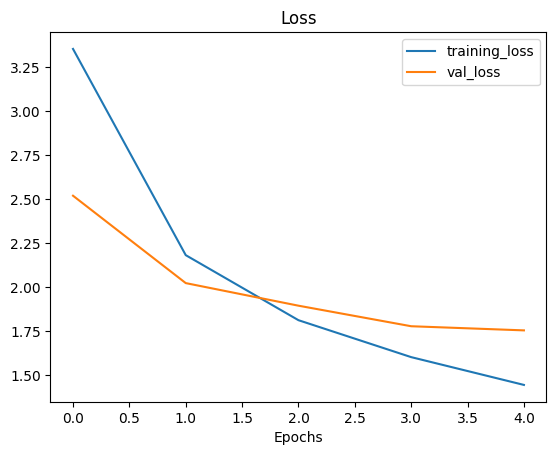

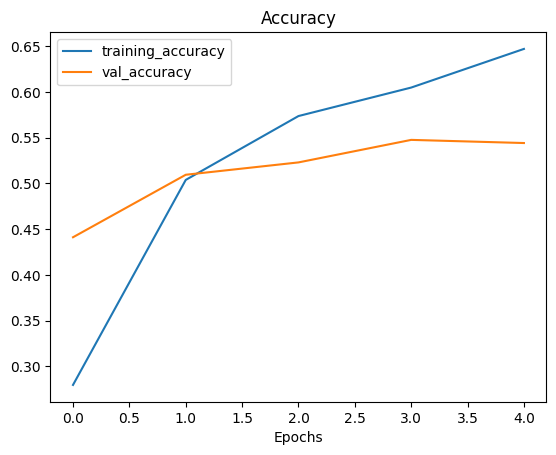

In [14]:
plot_loss_curves(history_all_classes_10_percent)

Looking at the curves, as the 2 curves should be very close to each other, which leads to situation where the model is overfitting

## Fine-tuning

In [32]:
#Unfreeze all of the layers in the base model 
base_model.trainable = True

#Refreeze the layers except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
#what layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_pool_layer True
output_layer True


In [35]:
for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_proj

In [36]:
#Fine Tune for 5 epochs
fine_tune_epochs=10 #model has already done 5 epochs feature extraction
initial_epochs=5

history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 70s 253ms/step - loss: 1.2089 - accuracy: 0.6807 - val_loss: 1.6766 - val_accuracy: 0.5527
Epoch 6/10
237/237 [==============================] - 54s 224ms/step - loss: 1.0954 - accuracy: 0.7023 - val_loss: 1.6647 - val_accuracy: 0.5601
Epoch 7/10
237/237 [==============================] - 50s 209ms/step - loss: 1.0126 - accuracy: 0.7283 - val_loss: 1.6720 - val_accuracy: 0.5580
Epoch 8/10
237/237 [==============================] - 44s 182ms/step - loss: 0.9459 - accuracy: 0.7468 - val_loss: 1.6563 - val_accuracy: 0.5638
Epoch 9/10
237/237 [==============================] - 60s 250ms/step - loss: 0.8823 - accuracy: 0.7644 - val_loss: 1.6677 - val_accuracy: 0.5577
Epoch 10/10
237/237 [==============================] - 50s 210ms/step - loss: 0.8471 - accuracy: 0.7725 - val_loss: 1.6957 - val_accuracy: 0.5514


In [51]:
all_classes_10_percent_fine_tune_results=model.evaluate(test_data)

790/790 [==============================] - 56s 70ms/step - loss: 1.8027 - accuracy: 0.6078


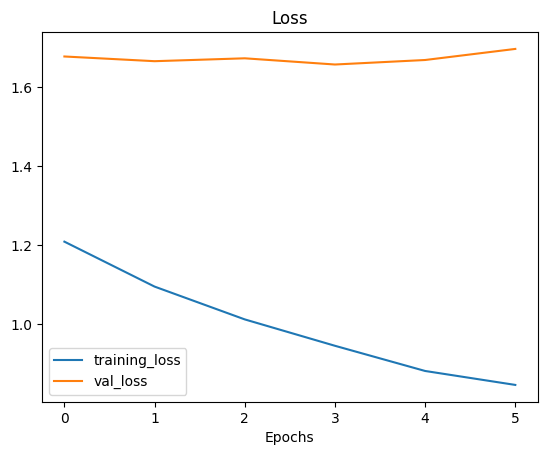

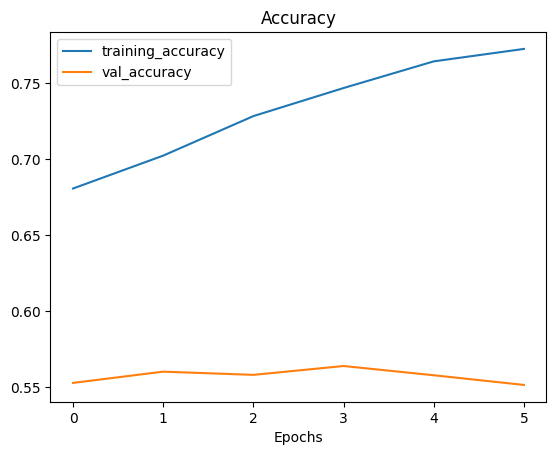

In [38]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

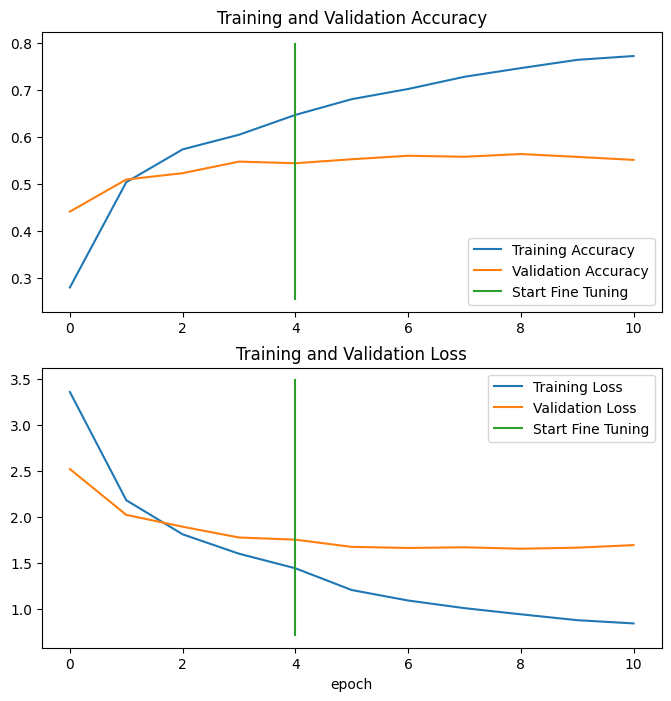

In [39]:
#compare the histories of feature extraction with fine-tuned model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)


## Saving and loading the model

To use the model in an extrnal app, we need to save and export it

In [41]:
#Save the model
#model.save("101_food_classes_model_fine_tuned_10_percent_data")

TypeError: ignored

In [ ]:
#Load and evaluate the saved model
# loaded_model =tf.keras.models.load_model("101_food_classes_model_fine_tuned_10_percent_data")

In [ ]:
# loaded_model.evaluate(test_data)

Let's make some predictions and vizualize them and see which ones were the most wrong

In [43]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-06-07 10:15:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   129MB/s    in 0.3s    

2023-06-07 10:15:03 (129 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [44]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [54]:
model=tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [55]:
results_downloaded_model=model.evaluate(test_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.8027 - accuracy: 0.6078


In [56]:
all_classes_10_percent_fine_tune_results

[1.8027206659317017, 0.6077623963356018]

In [58]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [59]:
preds_prob=model.predict(test_data, verbose=1) #set verbose to see how long is left

790/790 [==============================] - 68s 84ms/step


In [60]:
len(test_data)

790

In [62]:
len(preds_prob)

25250

In [63]:
preds_prob.shape

(25250, 101)

In [65]:
#Let's see what the first 10 predictions look like
preds_prob[10]

array([8.66758645e-01, 1.06682467e-08, 8.97231163e-04, 2.98574256e-11,
       1.19359580e-08, 2.52451636e-11, 1.78776531e-07, 1.49150314e-09,
       7.43701681e-02, 4.74565095e-05, 7.88795589e-08, 4.73205364e-10,
       9.88295884e-04, 4.71360728e-09, 9.51967086e-05, 3.80473146e-08,
       1.96486411e-07, 7.64913275e-04, 4.63440472e-07, 2.07787082e-07,
       3.97520722e-07, 6.02352031e-07, 2.73168621e-06, 7.80093444e-07,
       4.01718765e-08, 5.76192178e-08, 7.19973130e-08, 1.58951619e-11,
       2.75498496e-05, 6.87810189e-06, 1.76989190e-07, 2.09113641e-05,
       3.46416346e-05, 1.02143172e-11, 1.48571687e-07, 6.49165610e-10,
       1.37262277e-05, 3.96533096e-06, 2.23210191e-05, 2.05117967e-08,
       7.41940539e-06, 6.01402064e-07, 1.00604502e-05, 8.69767973e-08,
       1.21352750e-09, 4.20938818e-07, 1.28025931e-06, 3.94755872e-08,
       2.20744378e-11, 1.11111913e-04, 5.95505050e-08, 3.00479286e-09,
       2.45919097e-02, 1.49327952e-05, 4.66858739e-11, 2.53548904e-04,
      

In [68]:
preds_prob[0], len(preds_prob[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

In [69]:
import numpy as np
np.argmax(preds_prob[0])

52

In [72]:
train_data_all_10_percent.class_names[52]

'gyoza'

Our model outputs a prediction probabulity array (with N number of variables , where N is the number of classes ) for each sample passed to the prediction method

In [74]:
print(f"Number of prediction probabilities {len(preds_prob[0])}")
print(f"What prediction probability sample 0 looks like:{preds_prob[0]}" )
print(f"the hishgest value (predicted probab) by the model{preds_prob[0].argmax()}")

Number of prediction probabilities 101
What prediction probability sample 0 looks like:[5.9542079e-02 3.5742114e-06 4.1377071e-02 1.0660534e-09 8.1614422e-09
 8.6639478e-09 8.0927344e-07 8.5652732e-07 1.9859108e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532281e-04 7.8048890e-10 7.4230117e-04
 3.8916227e-05 6.4740480e-06 2.4977348e-06 3.7891161e-05 2.0678284e-07
 1.5538406e-05 8.1507324e-07 2.6230616e-06 2.0010684e-07 8.3827518e-07
 5.4215925e-06 3.7390960e-06 1.3150530e-08 2.7761441e-03 2.8051916e-05
 6.8562017e-10 2.5574853e-05 1.6688927e-04 7.6406986e-10 4.0452811e-04
 1.3150683e-08 1.7957391e-06 1.4448174e-06 2.3062844e-02 8.2466693e-07
 8.5365679e-07 1.7138593e-06 7.0525425e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681530e-06 1.8525149e-07 3.3619703e-08 3.1522504e-04
 1.0410941e-05 8.5448431e-07 8.4741855e-01 1.0555424e-05 4.4094787e-07
 3.7404032e-05 3.5306188e-05 3.2488941e-05 6.7314730e-05 1.2852589e-08
 2.6219654e-10 1.0318089e-05 8.5743537e-05 1.0569885e-06 2.12

In [77]:
#Get the pred classes of each label
pred_classes=preds_prob.argmax(axis=1)

#How do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [78]:
#How many pred_classes do we have
len(pred_classes)

25250